In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)
import math
import random
from scipy.stats import normaltest

<h1>Where are all my speeding tickets most likely to come from?</h1>

With our three data sources merged from Open Edmonton, we are ready to explore the photo radar and photo truck ticketing in Edmonton. I dealt with Nulls in the last booklet when preparing our data. You'll find that the file created is so massive that you can't host it in Github!
 
<h3> Assumptions </h3>
</u>
<li> All photo radar trucks operate on the same rules. No operator is making their own decisions on giving people tickets, the machine is treating all vehicles the same.
<li> All red light cameras are programmed the same. If one decides to not give a ticket when going 1-5 km over the speed limit then none of them do. 

In [2]:
df1=pd.read_csv('data/EdmontonTraffic.csv', parse_dates=[3], infer_datetime_format=True, dtype={0:'string'})
df1.head(2)

,Site ID,Location,Enforced Speed Limit,Month End Date,1-5 Over Speed Limit,6-10 Over Speed Limit,11-15 Over Speed Limit,16-20 Over Speed Limit,21-50 Over Speed Limit,51+ Over Speed Limit,Total Speeding Tickets,Latitude,Longitude,Red_Truck,Deployment Hours,Total Red Light Tickets,Year,Average Daily Volume,Month
0,7131,WB Anthony Henday Dr at 34 St,100,2019-08-31,0,0,4,6,1,0,11,53.435731,-113.395537,0,1.5,0,2019,2400.0,8
1,7131,WB Anthony Henday Dr at 34 St,100,2019-08-31,0,0,4,6,1,0,11,53.435731,-113.395537,0,1.5,0,2019,2400.0,8


In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359159 entries, 0 to 1359158
Data columns (total 19 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   Site ID                  1359159 non-null  string        
 1   Location                 1359159 non-null  object        
 2   Enforced Speed Limit     1359159 non-null  int64         
 3   Month End Date           1359159 non-null  datetime64[ns]
 4   1-5 Over Speed Limit     1359159 non-null  int64         
 5   6-10 Over Speed Limit    1359159 non-null  int64         
 6   11-15 Over Speed Limit   1359159 non-null  int64         
 7   16-20 Over Speed Limit   1359159 non-null  int64         
 8   21-50 Over Speed Limit   1359159 non-null  int64         
 9   51+ Over Speed Limit     1359159 non-null  int64         
 10  Total Speeding Tickets   1359159 non-null  int64         
 11  Latitude                 1359159 non-null  float64       
 12  

In [4]:
df1.rename(columns = {'Total Speeding Tickets':'radar_truck_tix','Total Red Light Tickets':'red_light_tix', 'Red_Truck':'red_light'}, inplace = True)

### Choose subset of columns to look at

In [5]:
df1=df1[['Location', 'Enforced Speed Limit',
       '1-5 Over Speed Limit', '6-10 Over Speed Limit',
       '11-15 Over Speed Limit', '16-20 Over Speed Limit',
       '21-50 Over Speed Limit', '51+ Over Speed Limit', 'radar_truck_tix',
       'red_light', 'Deployment Hours',
       'red_light_tix', 'Average Daily Volume', 'Month']]

## Create columns Total Tickets by incident and Average tickets/hr

In [6]:
df1["Total Tickets"]= df1['radar_truck_tix']+df1['red_light_tix']

In [7]:
df1['avgtickets_hr_total']=df1['Total Tickets']/df1["Deployment Hours"]

## we won't consider events that resulted in zero tickets and drop those. 

In [8]:
df1=df1[df1['Total Tickets']!=0]

### Asking Questions:
#### Basic Stats around Red-Light Tickets Vrs Radar Truck tickets

(0.0, 12567.4)

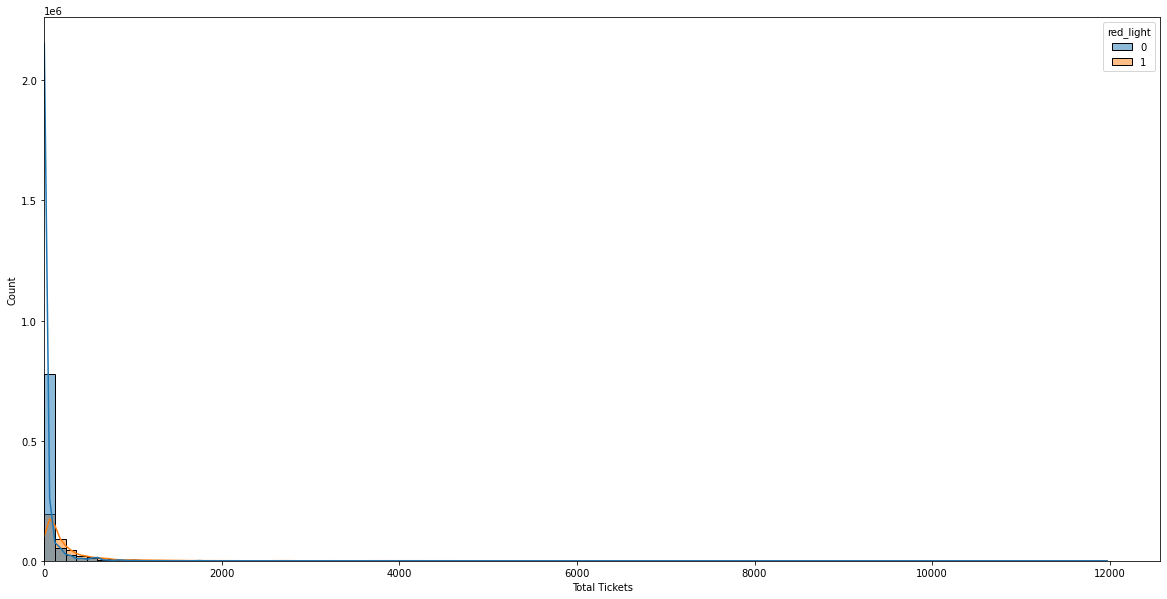

In [9]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

sns.histplot(
    data=df1.loc[(df1['Total Tickets'] !=0)],
    x='Total Tickets',
    ax=ax,
    bins=100,
    kde=True,
    hue="red_light"
)
ax.set_xlim(0)

In [11]:
df=df1.copy()

### Ticket distribution is FAR different between 0 (radar tickets) and 1 (red light tickets) populations.  Now let's statistically compare the red light ticket numbers to the radar truck ticket numbers and also test if distributions are normal or log normal at p=0.05. (we can already see they are exponential but why not test.)

In [12]:
def groupby_var(a, b, df=df):
    return df.groupby(a).agg(
        mean_all=(b, "mean"),
        std_all=(b, "std"),
        n_in_group=(b, "count"),
        mean_red=(b, lambda x: np.mean(x[x!=0])),
        std_red=(b, lambda x: np.std(x[x!=0])),
        n_red=(b, lambda x: sum(x != 0)),
        #normal test returns p
        normal_test=(b, lambda x: normaltest(x)[1]),
        #normal test on log Revenue returns p
        lognormal_test=(b, lambda x: normaltest(np.log(x[x!=0]))[1]),
        ).round(2)

In [13]:
groupby_var('red_light', "Total Tickets")

,mean_all,std_all,n_in_group,mean_red,std_red,n_red,normal_test,lognormal_test
red_light,,,,,,,,
0,60.94,153.22,890252,60.94,153.22,890252,0.0,0.0
1,281.60,580.22,409267,281.60,580.22,409267,0.0,0.0


<AxesSubplot:xlabel='Total Tickets', ylabel='Density'>

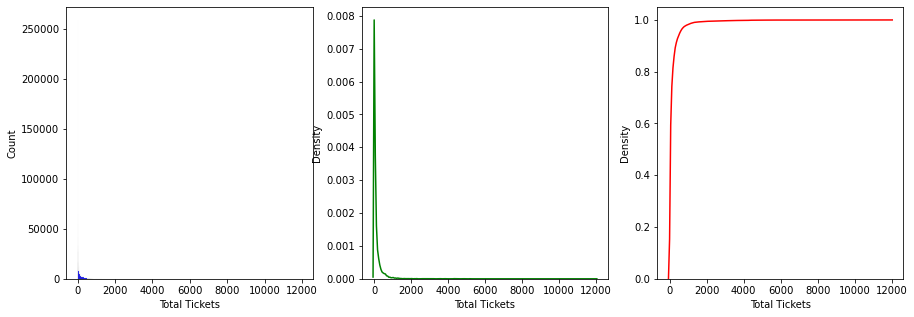

In [14]:
plt.rcParams["figure.figsize"] = (15,5)
fig, ax = plt.subplots(1,3)
sns.histplot(data=df, x="Total Tickets", color="blue", ax=ax[0])
sns.kdeplot(data=df, x="Total Tickets", color="green", ax=ax[1])
sns.kdeplot(data=df, x="Total Tickets", color="red", cumulative=True, ax=ax[2])

### Tickets are exponentially distribution.
### You are over four times as likely to get a Red Light Ticket then a Radar ticket.
### With our long right tail, we have some big ticketing locations
### let's investigate tickets type by average tickets given per hour 

In [18]:
groupby_var('red_light', 'avgtickets_hr_total')

,mean_all,std_all,n_in_group,mean_red,std_red,n_red,normal_test,lognormal_test
red_light,,,,,,,,
0,2.71,4.16,890252,2.71,4.16,890252,0.0,0.0
1,11.73,24.18,409267,11.73,24.18,409267,0.0,0.0


<AxesSubplot:xlabel='avgtickets_hr_total', ylabel='Density'>

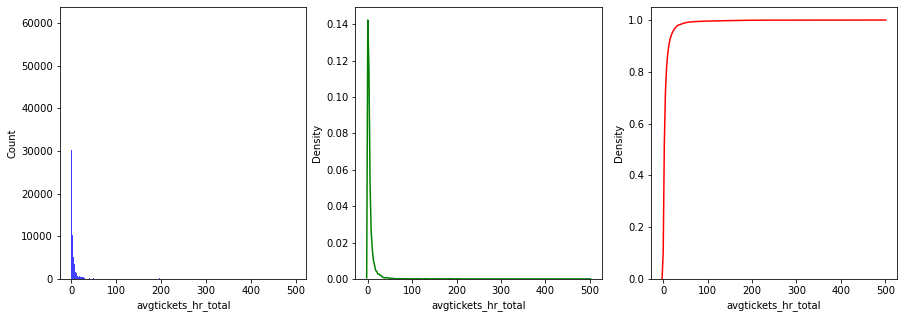

In [17]:
plt.rcParams["figure.figsize"] = (15,5)
fig, ax = plt.subplots(1,3)
sns.histplot(data=df, x='avgtickets_hr_total', color="blue", ax=ax[0])
sns.kdeplot(data=df, x='avgtickets_hr_total', color="green", ax=ax[1])
sns.kdeplot(data=df, x='avgtickets_hr_total', color="red", cumulative=True, ax=ax[2])

### The same observations hold for Average tickets per hour.
### let's find the top 1 percentile threshold of Average tickets per hour.

In [23]:
top1=np.percentile(df['avgtickets_hr_total'],99)
print('top 1 percentile threshold for AVG tickets/hr is: ', top1)

top 1 percentile threshold for AVG tickets/hr is:  51.5


Even though we cleared outliers, clearly there are very few locations giving out more than 20 tickets an hour. Let's dig and FIND those locations.

In [24]:
df_50plus=df[df[avgtickets_hr_total]>top1]

In [53]:
df50=df_50plus.groupby("Location").agg({'Enforced Speed Limit': ['max'],

'11-15 Over Speed Limit': ['sum'],
'16-20 Over Speed Limit': ['sum'],
'21-50 Over Speed Limit': ['sum'],
'51+ Over Speed Limit': ['sum'],
'radar_truck_tix': ['sum'],
'red_light_tix': ['sum'],
'Average Daily Volume': ['max'],
'Total Tickets': ['sum'],
'avgtickets_hr_total':['mean', 'std']})
df50

Enforced Speed Limit  \
                                                         max   
Location                                                       
(53.52090722245281,-113.53885659811326)                   50   
(53.57714222000001,-113.53072240999997)                   60   
EB Fox Dr @ Fort Edmonton Park Rd                         70   
EB Yellowhead Tr @ 107 St                                 70   
NB 50 St @ Ellerslie Rd                                   60   
NB 82 St @ 112 Ave                                        50   
NB Gateway Blvd @ 34 Ave                                  60   
NB Gateway Blvd @ Whitemud Drive EB                       60   
NB Mark Messier Trail @ Campbell Road                     70   
NB Rossdale Rd @ 97 Ave                                   50   
SB 127 St @ 126 Ave                                       50   
SB 170 St @ 118 Ave                                       60   
SB 50 St @ Ellerslie Rd                                   60   
SB Mark Messier Trail @ Campbell Road                     70   
WB Yellowhead Tr @ 107 St                                 70   

                                        11-15 Over Speed Limit  \
                                                           sum   
Location                                                         
(53.52090722245281,-113.53885659811326)                  19278   
(53.57714222000001,-113.53072240999997)                   9620   
EB Fox Dr @ Fort Edmonton Park Rd                       417960   
EB Yellowhead Tr @ 107 St                               188272   
NB 50 St @ Ellerslie Rd                                 188760   
NB 82 St @ 112 Ave                                      325210   
NB Gateway Blvd @ 34 Ave                               6427580   
NB Gateway Blvd @ Whitemud Drive EB                    2401216   
NB Mark Messier Trail @ Campbell Road                    94353   
NB Rossdale Rd @ 97 Ave                                1092000   
SB 127 St @ 126 Ave                                   13071024   
SB 170 St @ 118 Ave                                    1780102   
SB 50 St @ Ellerslie Rd                                 138384   
SB Mark Messier Trail @ Campbell Road                   141708   
WB Yellowhead Tr @ 107 St                               337275   

                                        16-20 Over Speed Limit  \
                                                           sum   
Location                                                         
(53.52090722245281,-113.53885659811326)                   2040   
(53.57714222000001,-113.53072240999997)                   1036   
EB Fox Dr @ Fort Edmonton Park Rd                        92232   
EB Yellowhead Tr @ 107 St                                26568   
NB 50 St @ Ellerslie Rd                                  37752   
NB 82 St @ 112 Ave                                       61370   
NB Gateway Blvd @ 34 Ave                               1461328   
NB Gateway Blvd @ Whitemud Drive EB                     413168   
NB Mark Messier Trail @ Campbell Road                    18375   
NB Rossdale Rd @ 97 Ave                                 189504   
SB 127 St @ 126 Ave                                    2495232   
SB 170 St @ 118 Ave                                     282674   
SB 50 St @ Ellerslie Rd                                  22872   
SB Mark Messier Trail @ Campbell Road                    28539   
WB Yellowhead Tr @ 107 St                                63225   

                                        21-50 Over Speed Limit  \
                                                           sum   
Location                                                         
(53.52090722245281,-113.53885659811326)                    510   
(53.57714222000001,-113.53072240999997)                    296   
EB Fox Dr @ Fort Edmonton Park Rd                        30384   
EB Yellowhead Tr @ 107 St                                 5904   
NB 50 St @ Ellerslie Rd                        

# 15 locations deliver the top 1% of AVG Tickets/hour

In [31]:
print('Just for reference:'), {'53.52090722245281,-113.53885659811326': '112 St @ 104 Ave', '53.57714222000001,-113.53072240999997':'121 St @ 122 Ave'}

Just for reference:


(None,
 {'53.52090722245281,-113.53885659811326': '112 St @ 104 Ave',
  '53.57714222000001,-113.53072240999997': '121 St @ 122 Ave'})